# Лабораторная работа 1: "Метод обратного распространения ошибки"

##### Цели работы
- Изучить метод обратного распространения ошибки для обучения глубоких нейронных сетей на примере двухслойной полносвязной нейронной сети (один скрытый слой)

##### Конфигурация нейронной сети
- Входной слой содержит w x h нейронов, что соответствует разрешению одноканального изображения (для изображений в базе MNIST составляет 28x28).
- Выходной слой содержит k нейронов, что соответствует количеству классов изображений (для задачи классификации рукописных цифр MNIST – 10 классов).
- Скрытый слой содержит s нейронов (параметр).
- Скорость обучения (learning rate), размер пачки данных (batch size), количество эпох являются параметрами метода обучения.
- В качестве функции активации на скрытом слое используется функция ReLU. В качестве функции активации на выходном слое используется функция softmax. Входной слой не содержит функцию активации.
- В качестве функции ошибки используется кросс-энтропия. Функция активации softmax вместе с функцией ошибки кросс-энтропия упрощают вывод формул.
- Набор параметров для демонстрации работы нейронной сети (и выложенные материалы и демонстрации в т/к выполняется на данных параметрах):
    - Размер пачки может меняться от 8 до 64 изображений (в зависимости от доступного объема памяти).
    - Скорость обучения - 0.1.
    - Количество скрытых нейронов s - 300.
    - Количество эпох – 20.


### Загрузка модулей

In [1]:
import numpy as np
import struct
from array import array
from os.path  import join
%matplotlib inline
import random
import matplotlib.pyplot as plt
import time

np.random.seed(42)

### Определение функций и классов

In [2]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)
    
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)
        index += 1

In [3]:
class Model:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.w1 = np.random.randn(self.input_size, self.hidden_size) * np.sqrt(2.0 / self.input_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.w2 = np.random.randn(self.hidden_size, self.output_size) * np.sqrt(2.0 / self.hidden_size)
        self.b2 = np.zeros((1, self.output_size))

    def relu(self, input):
        return np.maximum(0, input)
    
    def relu_derivative(self, input):
        return (input > 0).astype(float)
    
    def softmax(self, input):
        shifted_input = input - np.max(input, axis=1, keepdims=True)
        exp_values = np.exp(shifted_input)
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)
    
    def categorical_cross_entropy(self, labels, predictions):
        loss = -np.mean(np.sum(labels * np.log(predictions), axis=1))
        return loss

    def forward(self, input):
        self.z1 = np.dot(input, self.w1) + self.b1
        self.a1 = self.relu(self.z1)
        self.z2 = np.dot(self.a1, self.w2) + self.b2
        output = self.softmax(self.z2)
        return output
    
    def backward(self, input, labels, output, learning_rate, batch_size):
        dz2 = (output - labels) / batch_size

        dw2 = np.dot(self.a1.T, dz2)
        db2 = np.sum(dz2, axis=0, keepdims=True)

        dz1 = np.dot(dz2, self.w2.T) * self.relu_derivative(self.z1)
        dw1 = np.dot(input.T, dz1)
        db1 = np.sum(dz1, axis=0, keepdims=True)

        self.w1 -= learning_rate * dw1
        self.b1 -= learning_rate * db1
        self.w2 -= learning_rate * dw2
        self.b2 -= learning_rate * db2

    def train(self, x_train, y_train, number_of_epochs, learning_rate, batch_size):
        number_of_samples = x_train.shape[0]
        number_of_batches = int(np.ceil(number_of_samples / batch_size))
        
        indices = np.arange(number_of_samples)
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train[indices]

        history = {
            "loss": [],
            "accuracy": [],
        }

        for epoch in range(number_of_epochs):
            start_time = time.time()

            epoch_loss = 0
            correct = 0

            for batch_idx in range(0, number_of_samples, batch_size):
                x_batch = x_train_shuffled[batch_idx:batch_idx + batch_size]
                y_batch = y_train_shuffled[batch_idx:batch_idx + batch_size]

                output = self.forward(x_batch)

                loss = self.categorical_cross_entropy(y_batch, output)
                epoch_loss += loss

                predictions = np.argmax(output, axis=1)
                true_labels = np.argmax(y_batch, axis=1)
                correct += np.sum(predictions == true_labels)

                self.backward(x_batch, y_batch, output, learning_rate, batch_size)

            average_epoch_loss = epoch_loss / number_of_batches
            average_epoch_accuracy = (correct / number_of_samples) * 100

            end_time = time.time()
            epoch_time = end_time - start_time

            print(
                f"Эпоха {epoch + 1} / {number_of_epochs}",
                f"Ошибка: {average_epoch_loss:.4f}",
                f"Точность: {average_epoch_accuracy:.4f}",
                f"Время: {epoch_time:.2f}s")
            
            history["loss"].append(average_epoch_loss)
            history["accuracy"].append(average_epoch_accuracy)

        return history
    
    def test(self, x_test, y_test):
        output = self.forward(x_test)
        
        loss = self.categorical_cross_entropy(y_test, output)
        
        predictions = np.argmax(output, axis=1)
        true_labels = np.argmax(y_test, axis=1)
        
        accuracy = np.mean(predictions == true_labels) * 100
        
        print(
            f"Ошибка на тестовых данных: {loss:.4f}",
            f"Точность на текстовых данных: {accuracy:.2f}%"
        )
        
        return loss, accuracy

### Загрузка и проверка корректности данных

In [4]:
input_path = '/home/vitalii/source/deep-learning-unn-3sem/deep-learning-course-practice-2024/laboratory_work_1/ManukhovVV/data'

training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

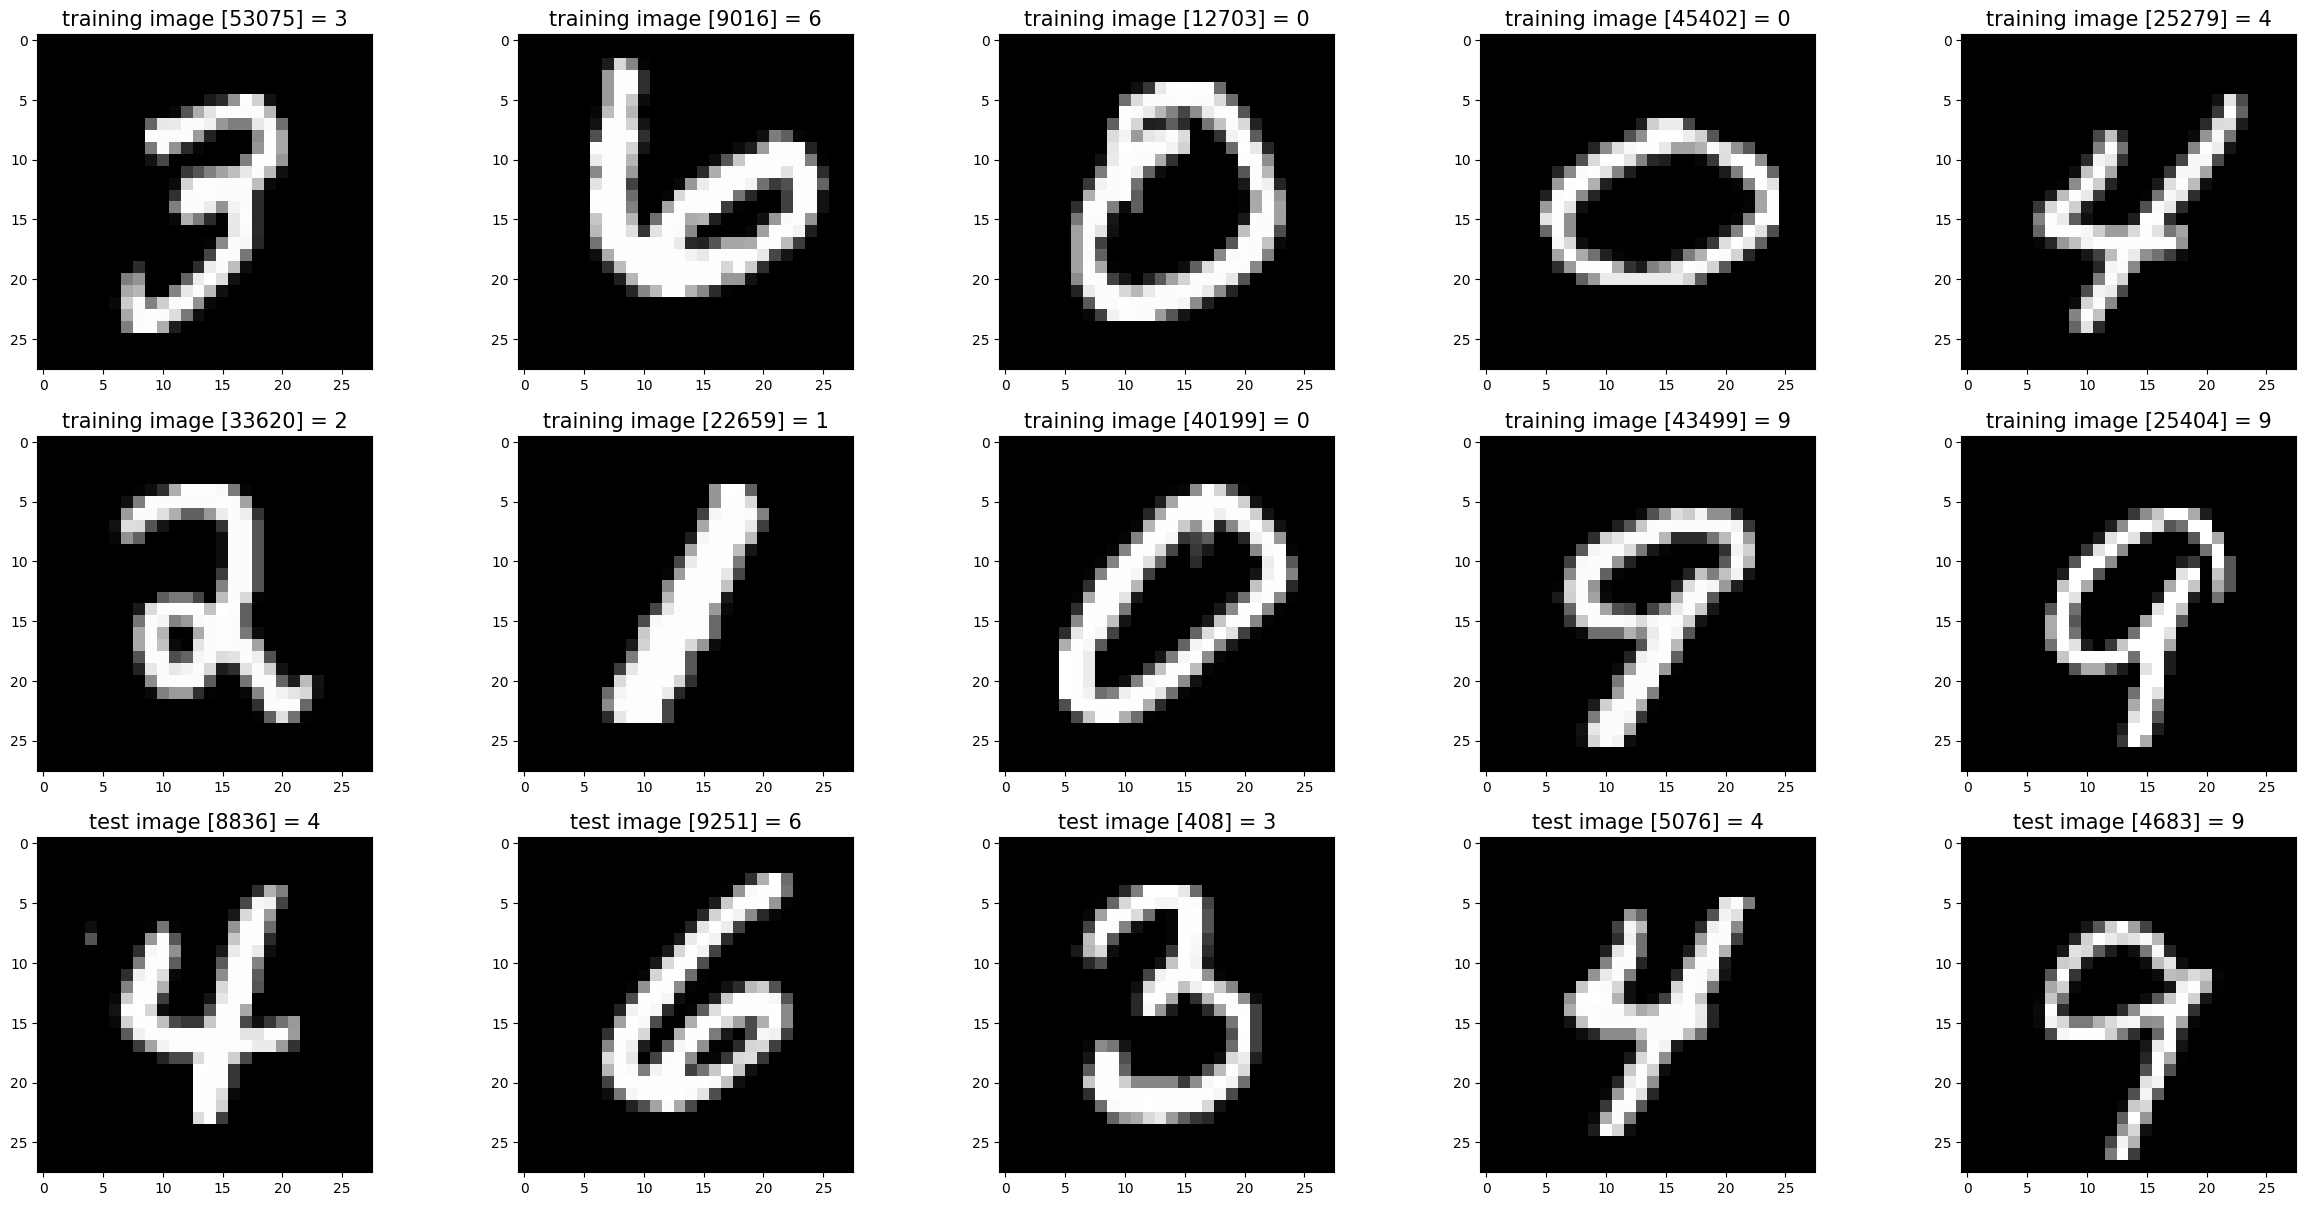

In [5]:
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)

In [6]:
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("Размерность тренировочных изоюражений: ", x_train.shape)
print("Размерность тестовых изображений: ", x_test.shape)
print("Размерность тренировочных меток: ", y_train.shape)
print("Размерность тестовых меток: ", y_train.shape)

Размерность тренировочных изоюражений:  (60000, 28, 28)
Размерность тестовых изображений:  (10000, 28, 28)
Размерность тренировочных меток:  (60000,)
Размерность тестовых меток:  (60000,)


Объект под индексом 0:
uint8 
 [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18

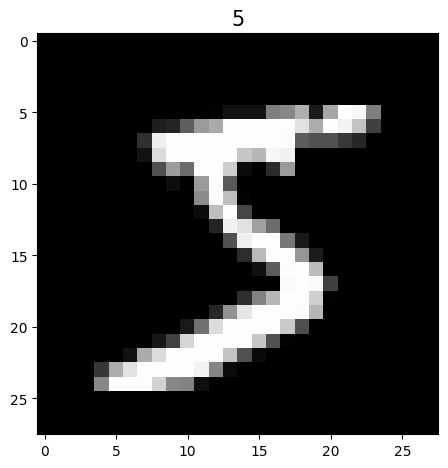

In [7]:
print("Объект под индексом 0:")
print(x_train.dtype, '\n', x_train[0])
print(y_train[0])

show_images([x_train[0]], [y_train[0]])

### Предобработка данных

In [8]:
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0

y_train_one_hot = np.zeros((y_train.size, 10))
y_train_one_hot[np.arange(y_train.size), y_train] = 1
y_test_one_hot = np.zeros((y_test.size, 10))
y_test_one_hot[np.arange(y_test.size), y_test] = 1

### Инициализация модели, тренировка и тестирование

In [9]:
input_size = 28 * 28
hidden_size = 300
output_size = 10
learning_rate = 0.1
number_of_epochs = 20
batch_size = 64  # 8 - 64

model = Model(input_size,
              hidden_size,
              output_size)

history = model.train(x_train, y_train_one_hot, number_of_epochs, learning_rate, batch_size)

model.test(x_test, y_test_one_hot)

Эпоха 1 / 20 Ошибка: 0.3599 Точность: 90.0083 Время: 2.22s
Эпоха 2 / 20 Ошибка: 0.1894 Точность: 94.6317 Время: 3.86s
Эпоха 3 / 20 Ошибка: 0.1395 Точность: 96.1150 Время: 2.01s
Эпоха 4 / 20 Ошибка: 0.1113 Точность: 96.8917 Время: 1.97s
Эпоха 5 / 20 Ошибка: 0.0927 Точность: 97.4483 Время: 2.17s
Эпоха 6 / 20 Ошибка: 0.0792 Точность: 97.8583 Время: 1.93s
Эпоха 7 / 20 Ошибка: 0.0687 Точность: 98.1750 Время: 1.97s
Эпоха 8 / 20 Ошибка: 0.0605 Точность: 98.4117 Время: 1.97s
Эпоха 9 / 20 Ошибка: 0.0536 Точность: 98.6383 Время: 1.88s
Эпоха 10 / 20 Ошибка: 0.0479 Точность: 98.7933 Время: 2.61s
Эпоха 11 / 20 Ошибка: 0.0430 Точность: 98.9367 Время: 2.81s
Эпоха 12 / 20 Ошибка: 0.0387 Точность: 99.0650 Время: 2.13s
Эпоха 13 / 20 Ошибка: 0.0350 Точность: 99.2050 Время: 2.11s
Эпоха 14 / 20 Ошибка: 0.0317 Точность: 99.3050 Время: 1.78s
Эпоха 15 / 20 Ошибка: 0.0288 Точность: 99.4083 Время: 1.78s
Эпоха 16 / 20 Ошибка: 0.0263 Точность: 99.4900 Время: 1.99s
Эпоха 17 / 20 Ошибка: 0.0240 Точность: 99.5367 Вр

(0.06505090295171638, 97.94)